In [2]:
# Authorization Header
# %python3 -m pip install --upgrade pip%pip install xgboost
import os
from alpaca.data.historical import StockHistoricalDataClient
from alpaca.data.requests import StockBarsRequest
from alpaca.data.timeframe import TimeFrame
import alpaca_trade_api as tradeapi
from sklearn.model_selection import train_test_split

import math
import time
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict

# ML
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score
import xgboost as xgb

API_KEY = ''
ENDPOINT = 'https://paper-api.alpaca.markets/v2'
API_SECRET = ''

# Set API keys from environment (recommended)
API_KEY_ENV = os.getenv('APCA_API_KEY_ID', API_KEY)
API_SECRET_ENV = os.getenv('APCA_API_SECRET_KEY', API_SECRET)

# Create client
client = StockHistoricalDataClient(API_KEY, API_SECRET)

api = tradeapi.REST(API_KEY, API_SECRET, ENDPOINT, api_version='v2')


In [3]:
from alpaca.data.historical import CryptoHistoricalDataClient

# No keys required for crypto data
client = CryptoHistoricalDataClient()

In [4]:
from alpaca.data.requests import CryptoBarsRequest

# Creating request object
request_params = CryptoBarsRequest(
  symbol_or_symbols=["BTC/USD"],
  timeframe=TimeFrame.Day,
  start=datetime(2025, 9, 10),
  end=datetime(2025, 9, 17)
)

In [4]:
# Getting data
#bars = client.get_crypto_bars(request_params)
#bars.df

In [5]:
import plotly as px
import plotly.graph_objects as go

BASE_URL = 'https://paper-api.alpaca.markets'

client = StockHistoricalDataClient(API_KEY, API_SECRET)

top10 = ["AAPL", "MSFT", "GOOGL", "AMZN", "NVDA",
         "META", "BRK.B", "TSLA", "UNH", "JPM"]



In [6]:
request = StockBarsRequest(
    symbol_or_symbols=top10,
    timeframe=TimeFrame.Day,
    start=datetime(2025, 1, 10),
    end=datetime(2025, 9, 17)
)

request_2 = StockBarsRequest(
    symbol_or_symbols=top10,
    timeframe=TimeFrame.Day,
    start=datetime(2024, 9, 10),
    end=datetime(2025, 1, 9)
)

bars = client.get_stock_bars(request)
bars_2 = client.get_stock_bars(request_2)

df = bars.df
df_2 = bars_2.df
  # MultiIndex: symbol + timestamp
print(df.head())


df.to_csv('data.csv')
df_2.to_csv('target.csv')

X = pd.read_csv("data.csv")
y = pd.read_csv("target.csv")


                                     open    high      low   close  \
symbol timestamp                                                     
MSFT   2025-01-10 05:00:00+00:00  424.630  424.71  415.020  418.95   
       2025-01-13 05:00:00+00:00  415.235  418.50  412.290  417.19   
       2025-01-14 05:00:00+00:00  417.810  419.74  410.720  415.67   
       2025-01-15 05:00:00+00:00  419.130  428.15  418.265  426.31   
       2025-01-16 05:00:00+00:00  428.695  429.49  424.390  424.58   

                                      volume  trade_count        vwap  
symbol timestamp                                                       
MSFT   2025-01-10 05:00:00+00:00  20201132.0     360661.0  419.245883  
       2025-01-13 05:00:00+00:00  17604780.0     305299.0  415.931109  
       2025-01-14 05:00:00+00:00  16935857.0     291484.0  415.426735  
       2025-01-15 05:00:00+00:00  19637838.0     306574.0  425.577611  
       2025-01-16 05:00:00+00:00  15300023.0     247931.0  426.043781  


In [7]:
# ✅ Stock data client
stock_client = StockHistoricalDataClient(API_KEY, API_SECRET)

# Example: request AAPL historical bars
bars_request = StockBarsRequest(
    symbol_or_symbols=top10,
    timeframe=TimeFrame.Day,
    start=datetime(2025, 1, 1),
    end=datetime(2025, 9, 1)
)
bars = stock_client.get_stock_bars(bars_request)
print(bars.df.head())



                                    open    high       low   close  \
symbol timestamp                                                     
MSFT   2025-01-02 05:00:00+00:00  425.53  426.07  414.8500  418.58   
       2025-01-03 05:00:00+00:00  421.08  424.03  419.5400  423.35   
       2025-01-06 05:00:00+00:00  428.00  434.32  425.4774  427.85   
       2025-01-07 05:00:00+00:00  429.00  430.65  420.8000  422.37   
       2025-01-08 05:00:00+00:00  423.46  426.97  421.5400  424.56   

                                      volume  trade_count        vwap  
symbol timestamp                                                       
MSFT   2025-01-02 05:00:00+00:00  16896469.0     353076.0  419.698066  
       2025-01-03 05:00:00+00:00  16662943.0     285046.0  422.518088  
       2025-01-06 05:00:00+00:00  20573648.0     372816.0  428.999489  
       2025-01-07 05:00:00+00:00  18139065.0     299265.0  424.525247  
       2025-01-08 05:00:00+00:00  15054575.0     249660.0  424.510336  


In [8]:
from alpaca.trading.client import TradingClient

trading_client = TradingClient(
    api_key=API_KEY,
    secret_key=API_SECRET,
    paper=True
)
trading_client.get_account()


{   'account_blocked': False,
    'account_number': 'PA3I8NAD1XSJ',
    'accrued_fees': '0',
    'buying_power': '185585.59',
    'cash': '92415.73',
    'created_at': datetime.datetime(2025, 9, 16, 22, 26, 20, 406440, tzinfo=TzInfo(UTC)),
    'crypto_status': <AccountStatus.ACTIVE: 'ACTIVE'>,
    'currency': 'USD',
    'daytrade_count': 0,
    'daytrading_buying_power': '0',
    'equity': '99959.6',
    'id': UUID('ae12191f-b017-4bc9-99ab-860459b461e9'),
    'initial_margin': '377.06',
    'last_equity': '99923.9173125',
    'last_maintenance_margin': '228.99',
    'long_market_value': '7543.87',
    'maintenance_margin': '226.24',
    'multiplier': '2',
    'non_marginable_buying_power': '92415.73',
    'options_approved_level': 3,
    'options_buying_power': '92792.79',
    'options_trading_level': 3,
    'pattern_day_trader': False,
    'pending_transfer_in': None,
    'pending_transfer_out': None,
    'portfolio_value': '99959.6',
    'regt_buying_power': '185585.59',
    'short_m

In [9]:
import pandas as pd

class Util:
    @staticmethod
    def to_dataframe(data):
        if isinstance(data, list):
            return pd.DataFrame([item.__dict__ for item in data])
        return pd.DataFrame(data, columns=['tag', 'value']).set_index('tag')


In [11]:
Util.to_dataframe(trading_client.get_account())

,value
tag,
id,ae12191f-b017-4bc9-99ab-860459b461e9
account_number,PA3I8NAD1XSJ
status,AccountStatus.ACTIVE
crypto_status,AccountStatus.ACTIVE
currency,USD
buying_power,185585.6
regt_buying_power,185585.6
daytrading_buying_power,0
non_marginable_buying_power,92415.73


In [12]:
Util.to_dataframe(trading_client.get_account_configurations())


,value
tag,
dtbp_check,DTBPCheck.ENTRY
fractional_trading,True
max_margin_multiplier,4
no_shorting,False
pdt_check,PDTCheck.ENTRY
suspend_trade,False
trade_confirm_email,TradeConfirmationEmail.ALL
ptp_no_exception_entry,False
max_options_trading_level,None


In [13]:
positions = trading_client.get_all_positions()
Util.to_dataframe(positions)

,asset_id,symbol,exchange,asset_class,asset_marginable,avg_entry_price,qty,side,market_value,cost_basis,...,unrealized_plpc,unrealized_intraday_pl,unrealized_intraday_plpc,current_price,lastday_price,change_today,swap_rate,avg_entry_swap_rate,usd,qty_available
0,b0b6dd9d-8b9b-48a9-ba46-b9d54906e415,AAPL,AssetExchange.NASDAQ,AssetClass.US_EQUITY,True,240.14,3,PositionSide.LONG,754.23,720.42,...,0.046930956941784,-9.06,-0.0118696694572181,251.41,254.43,-0.0118696694572181,None,None,None,3
1,64bbff51-59d6-4b3c-9351-13ad85e3c752,BTCUSD,AssetExchange.CRYPTO,AssetClass.CRYPTO,False,114394.374122807,0.05985,PositionSide.LONG,6789.7431,6846.503291,...,-0.0082903912533882,58.922325,0.0087541069610489,113446,112461.5,0.0087541069610489,None,None,None,0.05985


In [14]:
from alpaca.trading.requests import LimitOrderRequest,MarketOrderRequest
from alpaca.trading.enums import OrderSide, TimeInForce

order_data = MarketOrderRequest(
        symbol='BTC/USD',
        qty=0.01,
        side=OrderSide.BUY,
        time_in_force=TimeInForce.GTC)

market_order = trading_client.submit_order(order_data=order_data)

Util.to_dataframe(market_order)

,value
tag,
id,8d5e951a-6a67-43a3-8b36-ce6b0c13288f
client_order_id,e1e55933-74c0-4241-a794-90de69b712f5
created_at,2025-09-24 19:33:45.119504+00:00
updated_at,2025-09-24 19:33:45.120575+00:00
submitted_at,2025-09-24 19:33:45.119504+00:00
filled_at,None
expired_at,None
expires_at,2025-12-23 21:00:00+00:00
canceled_at,None


In [15]:
print(X.shape)
print(y.shape)

df.columns
bars = client.get_stock_bars(request)

# Reset the full MultiIndex into columns
df = bars.df.reset_index()  

print(df.head())
print(df.columns)

(1710, 9)
(840, 9)
  symbol                 timestamp     open    high       low   close  \
0  GOOGL 2025-01-10 05:00:00+00:00  194.295  196.52  190.3100  192.04   
1  GOOGL 2025-01-13 05:00:00+00:00  190.070  191.18  187.3600  191.01   
2  GOOGL 2025-01-14 05:00:00+00:00  191.240  191.98  188.3082  189.66   
3  GOOGL 2025-01-15 05:00:00+00:00  193.090  196.36  191.8600  195.55   
4  GOOGL 2025-01-16 05:00:00+00:00  194.140  195.48  192.8100  192.91   

       volume  trade_count        vwap  
0  26665206.0     379247.0  192.829352  
1  21823699.0     299678.0  190.096289  
2  17174854.0     236897.0  190.045694  
3  21775969.0     270843.0  194.800387  
4  17815432.0     243139.0  193.887075  
Index(['symbol', 'timestamp', 'open', 'high', 'low', 'close', 'volume',
       'trade_count', 'vwap'],
      dtype='object')


In [16]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# keep only numeric columns
X_num = X.select_dtypes(include=[np.number])

print("Original shape:", X.shape)
print("Numeric-only shape:", X_num.shape)

# scale numeric data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_num)

# run PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

print("Explained variance ratio:", pca.explained_variance_ratio_)



Original shape: (1710, 9)
Numeric-only shape: (1710, 7)
Explained variance ratio: [0.79572035 0.19727331]


In [17]:
min_len = min(len(X), len(y))
X = X[:min_len]
y = y[:min_len]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

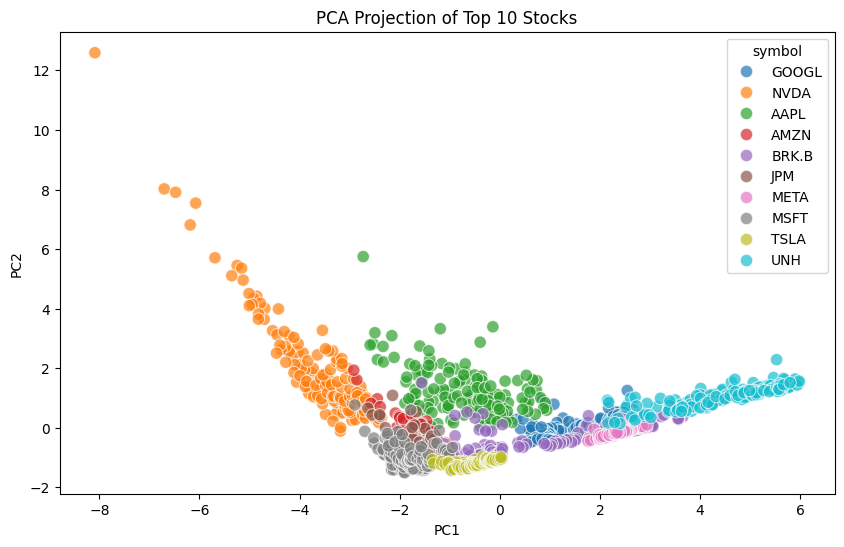

In [18]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# assuming you already have X_pca and df from your Alpaca data
df_pca = pd.DataFrame({
    "PC1": X_pca[:, 0],
    "PC2": X_pca[:, 1],
    "symbol": df["symbol"].values
})

plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_pca,
    x="PC1", y="PC2",
    hue="symbol",
    palette="tab10",
    s=80, alpha=0.7
)
plt.title("PCA Projection of Top 10 Stocks")
plt.show()



In [18]:
####
import finplot as fplt
import pandas as pd
import numpy as np

# Make sure your PCA dataframe exists
# df_pca = pd.DataFrame({
#     "PC1": X_pca[:, 0],
#     "PC2": X_pca[:, 1],
#     "symbol": df["symbol"].values
# })

# Ensure numeric columns
df_pca['PC1'] = pd.to_numeric(df_pca['PC1'], errors='coerce')
df_pca['PC2'] = pd.to_numeric(df_pca['PC2'], errors='coerce')

# Drop any rows with non-numeric values
df_pca = df_pca.dropna()

# Create a FinPlot window
fplt.create_plot("PCA Projection of Top 10 Stocks", init_zoom_periods=100)

# Plot each stock separately to color by symbol
palette = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']
for i, sym in enumerate(df_pca['symbol'].unique()):
    subset = df_pca[df_pca['symbol'] == sym]
    fplt.plot(
        subset['PC1'], 
        subset['PC2'], 
        style='o',  # marker-only
        color=palette[i % len(palette)], 
        legend=sym
    )

# Show the plot
fplt.show()


In [19]:
# Group by symbol
stocks = {sym: df[df['symbol'] == sym].copy() for sym in df['symbol'].unique()}

# Example: access Apple data
aapl_df = stocks['AAPL']
print(aapl_df.head())


    symbol                 timestamp     open    high      low   close  \
342   AAPL 2025-01-10 05:00:00+00:00  240.010  240.16  233.000  236.85   
343   AAPL 2025-01-13 05:00:00+00:00  233.530  234.67  229.720  234.40   
344   AAPL 2025-01-14 05:00:00+00:00  234.750  236.12  232.472  233.28   
345   AAPL 2025-01-15 05:00:00+00:00  234.635  238.96  234.430  237.87   
346   AAPL 2025-01-16 05:00:00+00:00  237.350  238.01  228.030  228.26   

         volume  trade_count        vwap  
342  61710856.0     685976.0  236.564899  
343  49630725.0     561231.0  232.601034  
344  39435294.0     436333.0  233.949347  
345  39831969.0     418804.0  237.596688  
346  71759052.0     786112.0  230.597381  


In [20]:
from sklearn.preprocessing import MinMaxScaler

# Select features
numeric_cols = ['open', 'high', 'low', 'close', 'volume']
data = aapl_df[numeric_cols].values

# Scale between 0 and 1
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# Create sequences (60 days → next day close)
sequence_length = 60
X, y = [], []
for i in range(sequence_length, len(data_scaled)):
    X.append(data_scaled[i-sequence_length:i])
    y.append(data_scaled[i, 3])  # close price

X, y = np.array(X), np.array(y)
print(X.shape, y.shape)


(111, 60, 5) (111,)


In [26]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

models = {}
histories = {}

for sym, df_sym in stocks.items():
    print(f"Training {sym}...")

    # Scale features
    scaler = MinMaxScaler()
    data_scaled = scaler.fit_transform(df_sym[numeric_cols].values)

    # Create sequences
    X, y = [], []
    for i in range(sequence_length, len(data_scaled)):
        X.append(data_scaled[i-sequence_length:i])
        y.append(data_scaled[i, 3])  # 3 = 'close' column
    X, y = np.array(X), np.array(y)

    # Define LSTM
    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=(X.shape[1], X.shape[2])),
        Dropout(0.2),
        LSTM(50),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')

    # Train (capture history)
    history = model.fit(X, y, epochs=30, batch_size=32, verbose=0, validation_split=0.2)

    # Save model, scaler, and history
    models[sym] = (model, scaler)
    histories[sym] = history

print("✅ Training finished for all 10 stocks!")


Training GOOGL...


/opt/miniconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Training NVDA...


/opt/miniconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Training AAPL...


/opt/miniconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Training AMZN...


/opt/miniconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Training BRK.B...


/opt/miniconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Training JPM...


/opt/miniconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Training META...


/opt/miniconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Training MSFT...


/opt/miniconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Training TSLA...


/opt/miniconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Training UNH...


/opt/miniconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Training finished for all 10 stocks!


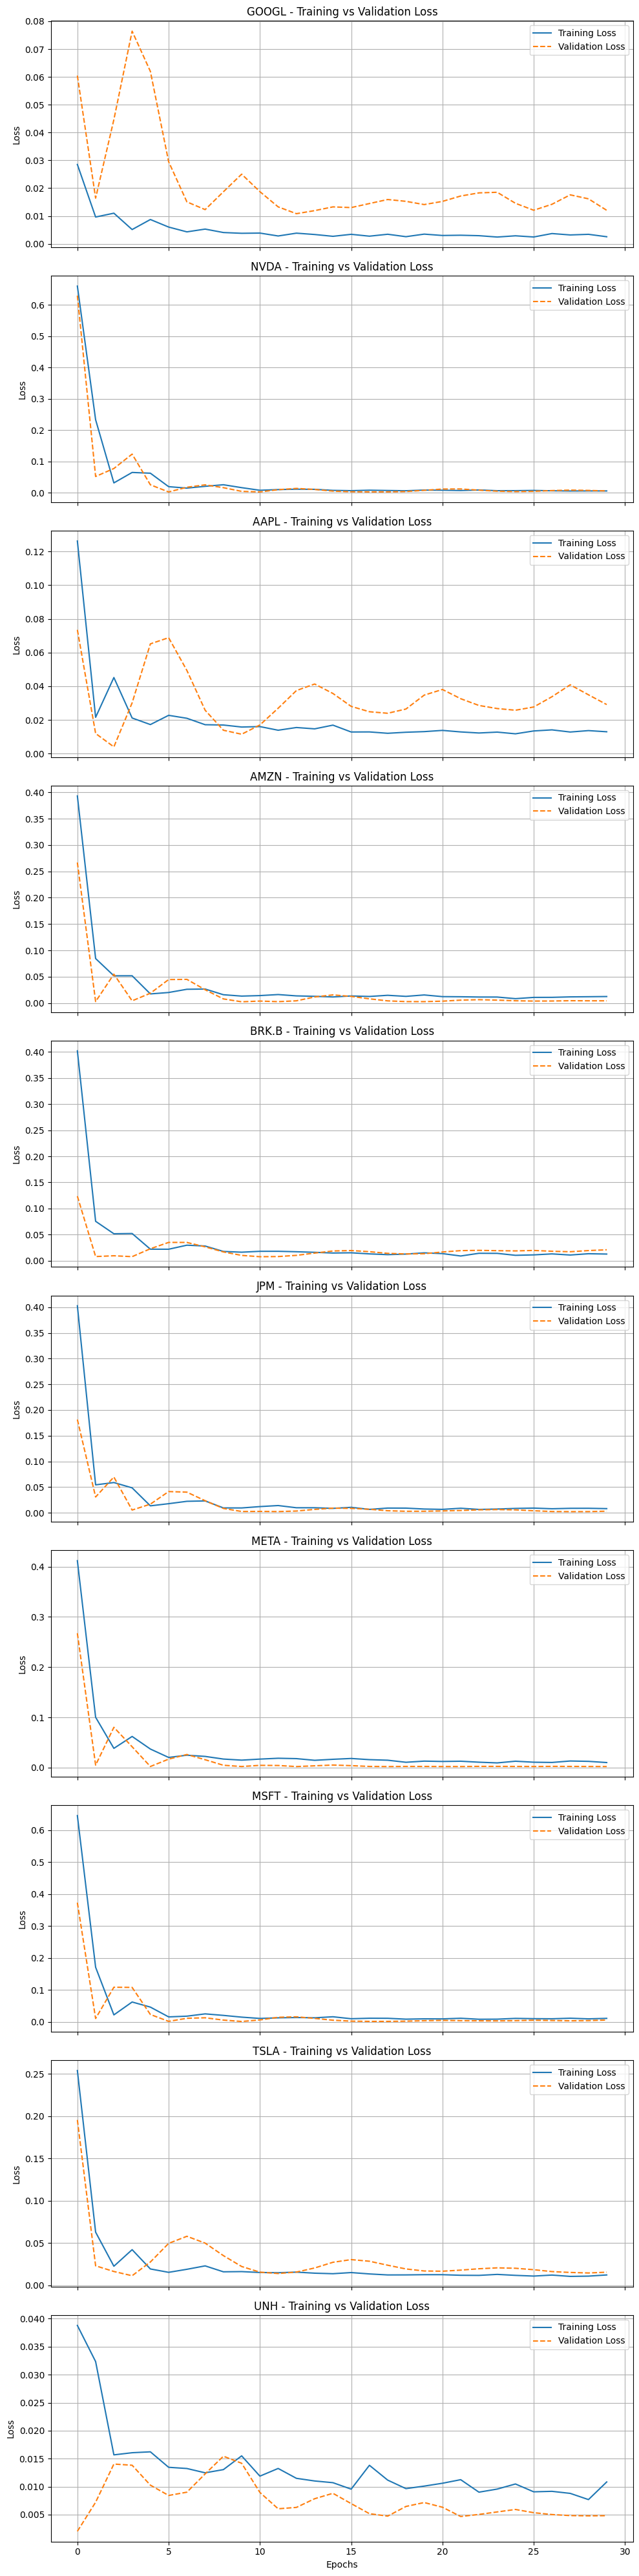

NameError: name 'fig' is not defined

In [27]:
import matplotlib.pyplot as plt
#  Training loss measures a model's error on the data it was trained on, while validation loss measures its error on unseen data
#  to check for generalization and detect overfitting. Ideally, both losses decrease steadily over time. However, if validation
#  loss starts to rise while training loss continues to fall, it indicates the model is memorizing the training data and needs 
#  adjustment
##
def plot_training_results(histories):
    n = len(histories)
    fig, axes = plt.subplots(n, 1, figsize=(10, 4*n), sharex=True)

    if n == 1:
        axes = [axes]

    for ax, (stock, history) in zip(axes, histories.items()):
        ax.plot(history.history['loss'], label='Training Loss')
        ax.plot(history.history['val_loss'], label='Validation Loss', linestyle='--')
        ax.set_title(f"{stock} - Training vs Validation Loss")
        ax.set_ylabel("Loss")
        ax.legend()
        ax.grid(True)

    axes[-1].set_xlabel("Epochs")
    plt.tight_layout()
    plt.show()

# Call it
plot_training_results(histories) 

fig.savefig("training_results_all_stocks.pdf", format="pdf", bbox_inches="tight")

In [29]:
predictions = {}

for sym, df_sym in stocks.items():
    model, scaler = models[sym]

    # Scale again with the stock's scaler
    data_scaled = scaler.transform(df_sym[numeric_cols].values)

    # Create sequences for prediction
    X, y_true = [], []
    for i in range(sequence_length, len(data_scaled)):
        X.append(data_scaled[i-sequence_length:i])
        y_true.append(data_scaled[i, 3])  # close column
    X, y_true = np.array(X), np.array(y_true)

    # Predict
    y_pred = model.predict(X, verbose=0).flatten()

    # Inverse transform back to price space
    # We need to reconstruct scaled array with predictions in the right column
    y_true_rescaled = []
    y_pred_rescaled = []

    for true_val, pred_val, seq in zip(y_true, y_pred, X):
        seq_copy = np.copy(seq[-1])  # last row in sequence as base
        seq_copy[3] = true_val
        y_true_rescaled.append(scaler.inverse_transform([seq_copy])[0][3])

        seq_copy[3] = pred_val
        y_pred_rescaled.append(scaler.inverse_transform([seq_copy])[0][3])

    predictions[sym] = (y_true_rescaled, y_pred_rescaled, df_sym.index[sequence_length:])


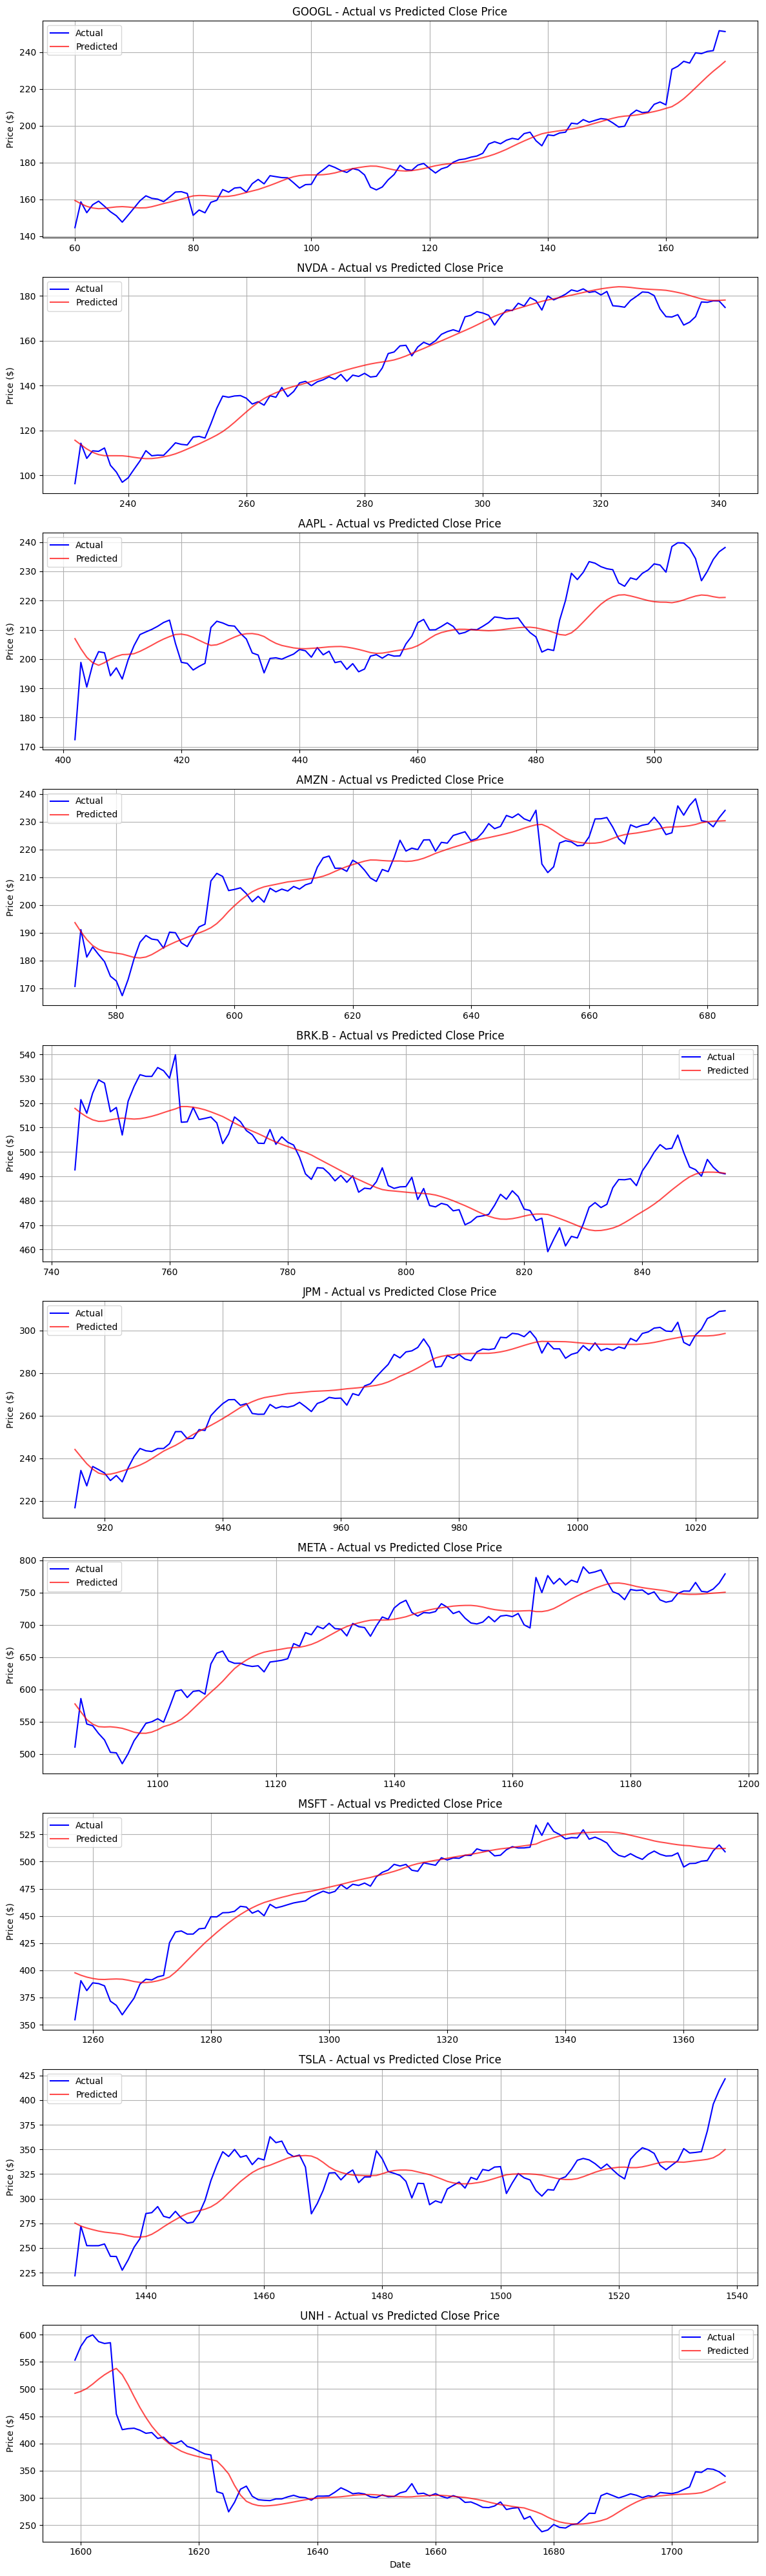

In [30]:
def plot_predictions(predictions):
    n = len(predictions)
    fig, axes = plt.subplots(n, 1, figsize=(12, 4*n), sharex=False)

    if n == 1:
        axes = [axes]

    for ax, (sym, (y_true, y_pred, dates)) in zip(axes, predictions.items()):
        ax.plot(dates, y_true, label="Actual", color="blue")
        ax.plot(dates, y_pred, label="Predicted", color="red", alpha=0.7)
        ax.set_title(f"{sym} - Actual vs Predicted Close Price")
        ax.set_ylabel("Price ($)")
        ax.legend()
        ax.grid(True)

    axes[-1].set_xlabel("Date")
    plt.tight_layout()
    plt.show()

# Call it
plot_predictions(predictions)


In [32]:
import finplot as fplt

finplot_predictions = {}

for sym, df_sym in stocks.items():
    model, scaler = models[sym]

    # Scale
    data_scaled = scaler.transform(df_sym[numeric_cols].values)

    # Create sequences
    X, y_true = [], []
    for i in range(sequence_length, len(data_scaled)):
        X.append(data_scaled[i-sequence_length:i])
        y_true.append(data_scaled[i, 3])  # close column
    X, y_true = np.array(X), np.array(y_true)

    # Predict
    y_pred = model.predict(X, verbose=0).flatten()

    # Rescale both actual + predicted
    y_true_rescaled, y_pred_rescaled = [], []
    for true_val, pred_val, seq in zip(y_true, y_pred, X):
        seq_copy = np.copy(seq[-1])

        # true
        seq_copy[3] = true_val
        y_true_rescaled.append(scaler.inverse_transform([seq_copy])[0][3])

        # pred
        seq_copy[3] = pred_val
        y_pred_rescaled.append(scaler.inverse_transform([seq_copy])[0][3])

    finplot_predictions[sym] = {
        "dates": df_sym.index[sequence_length:],
        "y_true": y_true_rescaled,
        "y_pred": y_pred_rescaled,
    }


In [35]:
# One chart window with stacked plots (one per stock)
for sym, pred in finplot_predictions.items():
    ax = fplt.create_plot(f"{sym} - Actual vs Predicted", rows=1)
    
    # Actual close prices (blue line)
    fplt.plot(pred["dates"], pred["y_true"], legend="Actual", color="blue", ax=ax)
    
    # Predicted close prices (red line)
    fplt.plot(pred["dates"], pred["y_pred"], legend="Predicted", color="red", ax=ax)
    fplt.show()


In [37]:
import finplot as fplt
from PyQt5.QtWidgets import QApplication

# Create chart
ax = fplt.create_plot("Example", rows=1)
fplt.plot(pred["dates"], pred["y_true"], legend="Actual", color="blue", ax=ax)
fplt.plot(pred["dates"], pred["y_pred"], legend="Predicted", color="red", ax=ax)

# Get the Qt widget (graphics window)
win = ax.vb.win

# Save screenshot as PNG
pixmap = win.grab()  
pixmap.save("prediction_vs_actual.png")

# Convert PNG to PDF (optional, using PIL)
from PIL import Image
img = Image.open("prediction_vs_actual.png")
img.convert("RGB").save("prediction_vs_actual.pdf")



objc[64753]: Class QT_ROOT_LEVEL_POOL__THESE_OBJECTS_WILL_BE_RELEASED_WHEN_QAPP_GOES_OUT_OF_SCOPE is implemented in both /opt/miniconda3/lib/python3.12/site-packages/PyQt6/Qt6/lib/QtCore.framework/Versions/A/QtCore (0x15d069640) and /opt/miniconda3/lib/python3.12/site-packages/PyQt5/Qt5/lib/QtCore.framework/Versions/5/QtCore (0x1dfd629c0). One of the two will be used. Which one is undefined.
objc[64753]: Class KeyValueObserver is implemented in both /opt/miniconda3/lib/python3.12/site-packages/PyQt6/Qt6/lib/QtCore.framework/Versions/A/QtCore (0x15d069668) and /opt/miniconda3/lib/python3.12/site-packages/PyQt5/Qt5/lib/QtCore.framework/Versions/5/QtCore (0x1dfd629e8). One of the two will be used. Which one is undefined.
objc[64753]: Class RunLoopModeTracker is implemented in both /opt/miniconda3/lib/python3.12/site-packages/PyQt6/Qt6/lib/QtCore.framework/Versions/A/QtCore (0x15d0696b8) and /opt/miniconda3/lib/python3.12/site-packages/PyQt5/Qt5/lib/QtCore.framework/Versions/5/QtCore (0x1d